# Meta Evaluation

This Notebook builds on top of the `1a_dataloader_example` and demonstrates
1. Training network and comparing performance for different dataset examples (function types)

In [1]:
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from utils import plot

In [2]:
# %matplotlib widget
%matplotlib inline

from matplotlib import rcParams
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})

## Network Definition

In [3]:
class Net(nn.Module):
    def __init__(self,
        N_in, N_out, N_hid, N_layers,
        loss_func=nn.MSELoss(),
        LEARNING_RATE = 0.001,
        optimizer = optim.Adam,
        use_grad=False,
        act_func=nn.LeakyReLU()):
        
        super(Net, self).__init__()
        self.layers = nn.Sequential(
                nn.Linear(in_features=N_in,
                    out_features=N_hid,
                    bias=True),
                act_func,
                *(nn.Linear(in_features=N_hid,
                    out_features=N_hid,
                    bias=True), act_func)*(N_layers - 1),
                nn.Linear(in_features=N_hid,
                    out_features=N_out,
                    bias=True)
            )
        
        self.loss_func = loss_func
        self.optimizer = optimizer(self.parameters(), lr=LEARNING_RATE)
        self.use_grad = use_grad
        
    def forward(self, x):
        out = self.layers(x)
        return out

    def loss(self, x, y, y_grad=None):
        out = self.forward(x)
        loss = self.loss_func(y, out)
        if self.use_grad:
            out_grad = torch.autograd.grad(out, x, torch.ones(x.shape), create_graph=True)[0]
            loss += self.loss_func(y_grad, out_grad)
        return loss
    
    def step(self, x, y, y_grad=None):
        self.train()
        self.optimizer.zero_grad()
        loss = self.loss(x, y, y_grad)
        loss.backward(retain_graph=True)
        self.optimizer.step()
        self.eval()
        return loss.detach()

In [4]:
from torch.utils.data import DataLoader
from sklearn.model_selection import ShuffleSplit
from torch.utils.data import SubsetRandomSampler

def train(dataset,
    max_epochs=100, batch_size = 10, loss_tolerance = None,
    N_hid=252, N_layers = 4, use_grad=False):
    '''
    Train NN on dataset using holdout validation.
    Returns: losses_train, losses_test, net
    '''
    x, y, y_grad = dataset[:]
    N_in = x.shape[1]
    N_out = y.shape[1]

    # Split dataset into train and test set (without stratification).
    shuffleSplit = ShuffleSplit(n_splits=1, test_size=.25).split(x)
    train_ids, test_ids = next(iter(shuffleSplit))

    train_sampler = SubsetRandomSampler(train_ids)
    train_loader = torch.utils.data.DataLoader(
                        dataset, 
                        batch_size=batch_size,
                        sampler=train_sampler)

    net = Net(N_in, N_out, N_hid=N_hid, N_layers=N_layers, use_grad=use_grad)

    losses_train = torch.zeros(max_epochs)
    losses_test = torch.zeros(max_epochs)

    for epoch in range(max_epochs):
        if (loss_tolerance != None):
            if (net.loss(x[train_ids], y[train_ids], y_grad[train_ids]) < loss_tolerance):
                break
        
        current_loss = 0.0
        for batch in train_loader:
            x_train, y_train, y_train_grad = batch
            current_loss += net.step(x_train, y_train, y_train_grad)
        RMSE_train = torch.sqrt(current_loss / len(train_loader))
        losses_train[epoch] = RMSE_train

        # Evaluation against test set
        x_test, y_test, y_grad_test = dataset[test_ids]
        RMSE_test = torch.sqrt(net.loss(x_test, y_test, y_grad_test)).item()
        losses_test[epoch] = RMSE_test

    return losses_train, losses_test, net

## 1D

### Define Dataset 

In [5]:
from DatasetFunction1D_advanced import DatasetFunction1D, func_types, func_expressions, func_derivatives, func_titles

number_of_functions = len(func_types)
datasets = []

for i, func_type in enumerate(func_types):
    # Define dataset
    x = torch.linspace(-3,3, 100, requires_grad=True).reshape(-1,1)
    dataset = DatasetFunction1D(x, func_type=func_type)
    datasets.append(dataset)

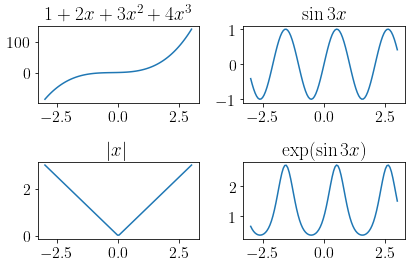

In [6]:
for i, func_type in enumerate(func_types):
    plt.subplot(int(number_of_functions/2), 2, i+1)
    x, y, y_grad = datasets[i][:]
    plot(x, y)
    plt.title(func_expressions[i])
plt.tight_layout()

### Train NN on Different Datasets

Train without using the gradient:

In [7]:
trains_no_grad = [train(dataset, max_epochs=500) for dataset in datasets]

Train using the gradient:

In [8]:
trains_use_grad = [train(dataset, max_epochs=500, use_grad=True) for dataset in datasets]

### Evaluation

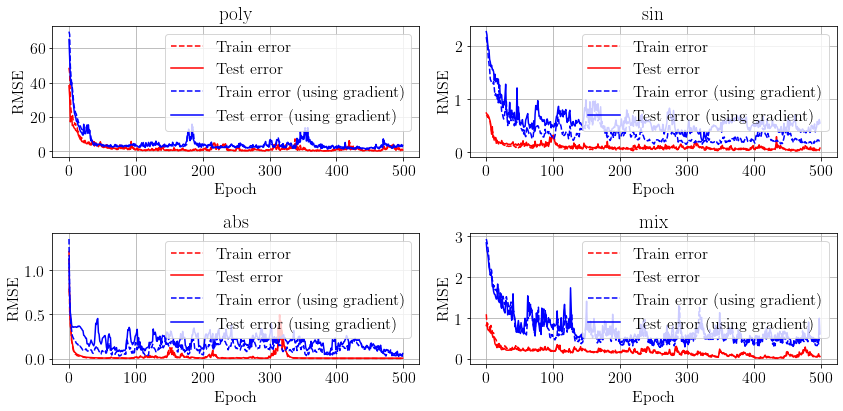

In [9]:
plt.figure(figsize=(12,6))
for i, func_type in enumerate(func_types):
    losses_train_no_grad, losses_test_no_grad, _ = trains_no_grad[i]
    losses_train_use_grad, losses_test_use_grad, _ = trains_use_grad[i]
    epochs = torch.count_nonzero(losses_train_no_grad)

    plt.subplot(int(number_of_functions/2),2,i+1)
    plot(range(epochs), losses_train_no_grad, '--r')
    plot(range(epochs), losses_test_no_grad, '-r')
    plot(range(epochs), losses_train_use_grad, '--b')
    plot(range(epochs), losses_test_use_grad, '-b')
    plt.title(func_type)
    plt.legend(['Train error', 'Test error', 'Train error (using gradient)', 'Test error (using gradient)'])
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.grid()

plt.tight_layout()

### Interpolated data

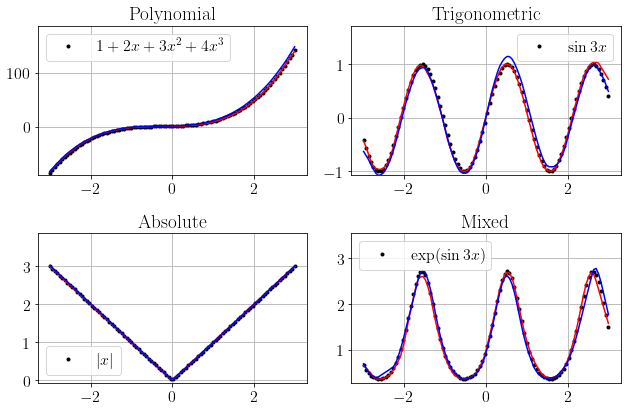

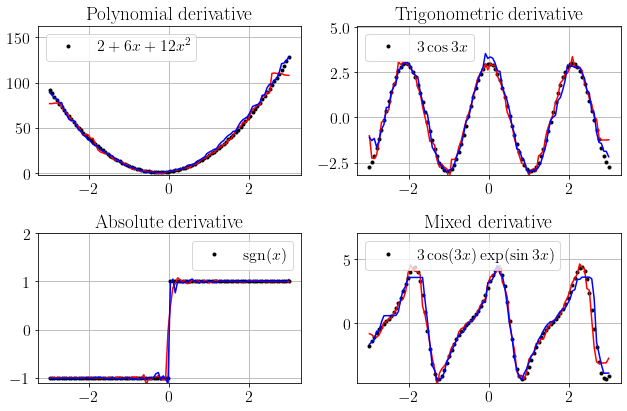

In [10]:
for i, func_type in enumerate(func_types):
    _, _, net_no_grad = trains_no_grad[i]
    _, _, net_use_grad = trains_use_grad[i]
    x, y, y_grad = datasets[i][:]

    plt.figure(1, figsize=(9, 6))
    plt.subplot(int(number_of_functions/2),2,i+1)
    out_no_grad = net_no_grad(x)
    out_use_grad = net_use_grad(x)
    plot(x, y, '.k')
    plt.ylim(y.min().item() - 0.1*y.std().item(), y.max().item() + y.std().item())
    plt.title(func_titles[i])
    plot(x, out_no_grad, 'r')
    plot(x, out_use_grad, 'b')
    plt.legend([func_expressions[i]])
    plt.grid()
    plt.tight_layout()

    plt.figure(2, figsize=(9, 6))
    plt.subplot(int(number_of_functions/2),2,i+1)
    plt.title(func_type)
    out_no_grad_x = torch.autograd.grad(net_no_grad(x), x, torch.ones(x.shape))[0]
    out_use_grad_x = torch.autograd.grad(net_use_grad(x), x, torch.ones(x.shape))[0]
    plot(x,y_grad, '.k')
    plt.ylim(y_grad.min().item() - 0.1*y_grad.std().item() , y_grad.max().item() + y_grad.std().item())
    plt.title(func_titles[i] + ' derivative')
    plot(x,out_no_grad_x, 'r')
    plot(x,out_use_grad_x, 'b')
    plt.legend([func_derivatives[i]])
    plt.grid()
    plt.tight_layout()

### Extrapolated data

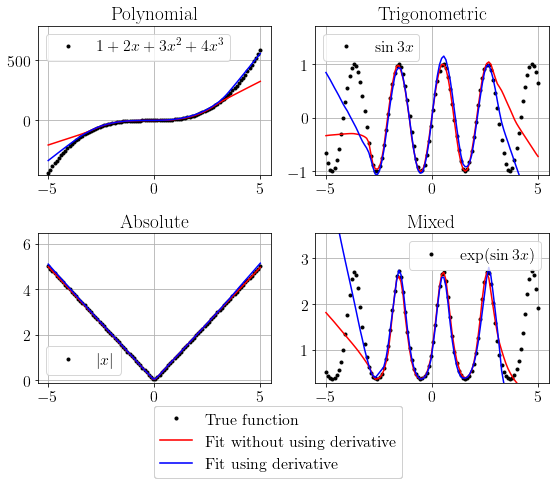

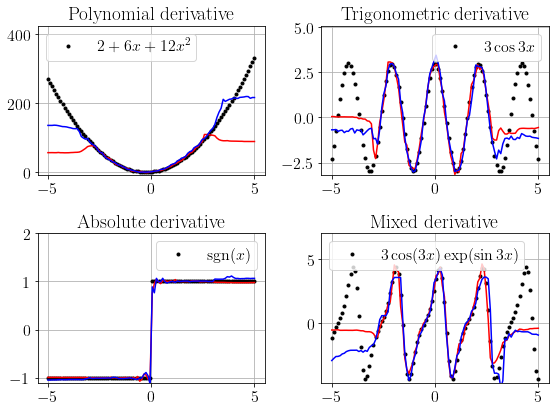

In [11]:
for i, func_type in enumerate(func_types):
    _, _, net_no_grad = trains_no_grad[i]
    _, _, net_use_grad = trains_use_grad[i]
    # Define dataset
    dataset_ext = DatasetFunction1D(
        torch.linspace(-5,5, 100, requires_grad=True).reshape(-1,1),
        func_type=func_type)
    x, y, y_grad = dataset_ext[:]

    f1 = plt.figure(1, figsize=(8, 6))
    plt.subplot(int(number_of_functions/2),2,i+1)
    out_no_grad = net_no_grad(x)
    out_use_grad = net_use_grad(x)
    plot(x, y, '.k')
    plt.ylim(y.min().item() - 0.1*y.std().item(), y.max().item() + y.std().item())
    plt.title(func_titles[i])
    plot(x, out_no_grad, 'r')
    plot(x, out_use_grad, 'b')
    plt.legend([func_expressions[i]])
    plt.grid()
    f1.legend(['True function', 'Fit without using derivative', 'Fit using derivative'], loc = 'lower center', bbox_to_anchor = (0,-0.15,1,1),
            bbox_transform = plt.gcf().transFigure)
    plt.tight_layout()

    f2 = plt.figure(2, figsize=(8, 6))
    plt.subplot(int(number_of_functions/2),2,i+1)
    plt.title(func_type)
    out_no_grad_x = torch.autograd.grad(net_no_grad(x), x, torch.ones(x.shape))[0]
    out_use_grad_x = torch.autograd.grad(net_use_grad(x), x, torch.ones(x.shape))[0]
    plot(x,y_grad, '.k')
    plt.ylim(y_grad.min().item() - 0.1*y_grad.std().item() , y_grad.max().item() + y_grad.std().item())
    plt.title(func_titles[i] + ' derivative')
    plot(x,out_no_grad_x, 'r')
    plot(x,out_use_grad_x, 'b')
    plt.legend([func_derivatives[i]])
    plt.grid()
    plt.tight_layout()

f1.savefig('./plots/1d-function-fit.pdf', bbox_inches='tight')
f2.savefig('./plots/1d-function-grad-fit.pdf', bbox_inches='tight')

### NN Parameter Variation

**Number of hidden units**

In [12]:
from timeit import default_timer as timer

In [13]:
N_hids = [2**p for p in range(3, 12)] # Number of hidden units are tested in powers of 2.
P = len(N_hids)
losses_NN_params = torch.zeros(P)
dataset = datasets[1]
func_type = func_types[1]

In [14]:
for p, N_hid in enumerate(N_hids):
    _, losses_test, _ = train(dataset, N_hid=N_hid, max_epochs=100)
    losses_NN_params[p] = losses_test[-1]
    print("trained " + str(N_hid) + " hidden units.")

trained 8 hidden units.
trained 16 hidden units.
trained 32 hidden units.
trained 64 hidden units.
trained 128 hidden units.


In [ ]:
max_epochs = 100
train_times = torch.zeros(P)
losses_with_tolerance_train = torch.zeros(P, max_epochs)
losses_with_tolerance_test = torch.zeros(P, max_epochs)
epochs_with_tolerance = torch.zeros(P)

for p, N_hid in enumerate(N_hids):
    start = timer()
    losses_train, losses_test, _ = train(dataset, N_hid=N_hid, N_layers=4, loss_tolerance=1, max_epochs=max_epochs)
    end = timer()
    time = end - start
    train_times[p] = time
    print("trained " + str(N_hid) + " hidden units in " + str(round(time, 2)) + " s.")
    epochs_with_tolerance[p] = torch.count_nonzero(losses_train)
    losses_with_tolerance_train[p,:] = losses_train
    losses_with_tolerance_test[p,:] = losses_test

trained 8 hidden units in 2.78 s.
trained 16 hidden units in 1.73 s.
trained 32 hidden units in 1.31 s.
trained 64 hidden units in 0.9 s.
trained 128 hidden units in 0.76 s.
trained 256 hidden units in 0.73 s.
trained 512 hidden units in 2.57 s.
trained 1024 hidden units in 13.35 s.
trained 2048 hidden units in 36.24 s.


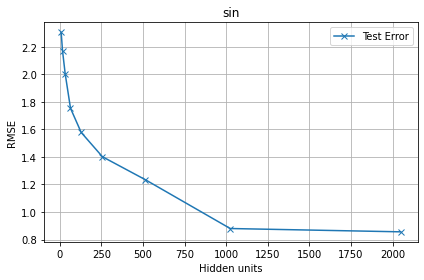

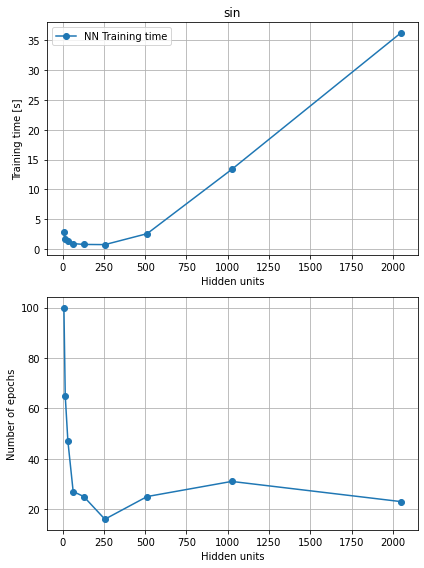

In [ ]:
plot(N_hids, losses_NN_params, '-x')
plt.title(func_type)
plt.legend(['Test Error'])
plt.xlabel('Hidden units')
plt.ylabel('RMSE')
plt.grid()

plt.tight_layout()

plt.figure(figsize=(6,8))
plt.subplot(2, 1, 1)
plot(N_hids, train_times, '-o')
plt.title(func_type)
plt.legend(['NN Training time'])
plt.xlabel('Hidden units')
plt.ylabel('Training time [s]')
plt.grid()

plt.subplot(2, 1, 2)
plot(N_hids, epochs_with_tolerance, '-o')
plt.xlabel('Hidden units')
plt.ylabel('Number of epochs')
plt.grid()

plt.tight_layout()

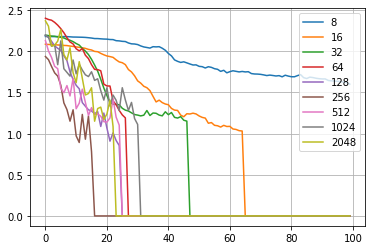

In [ ]:
plot(range(max_epochs), losses_with_tolerance_test.T)
plt.legend([str(N_hid) for N_hid in N_hids])
plt.grid()
plt.show()

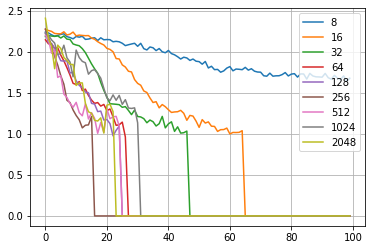

In [ ]:
plot(range(max_epochs), losses_with_tolerance_train.T)
plt.legend([str(N_hid) for N_hid in N_hids])
plt.grid()
plt.show()

In [ ]:
N_layers_list = [2**p for p in range(5)] # Number of hidden layers are tested in powers of 2.
P = len(N_layers_list)
train_times_hidden_layers = torch.zeros(P)
losses_hidden_layers_train = torch.zeros(P, max_epochs)
losses_hidden_layers_test = torch.zeros(P, max_epochs)
epochs_hidden_layers = torch.zeros(P)

for p, N_layers in enumerate(N_layers_list):
    start = timer()
    losses_train, losses_test, _ = train(dataset, N_layers=N_layers, N_hid=2**9, loss_tolerance=1, max_epochs=max_epochs)
    end = timer()
    time = end - start
    train_times_hidden_layers[p] = time
    print("trained " + str(N_layers) + " hidden layers in " + str(round(time, 2)) + " s.")
    epochs_hidden_layers[p] = torch.count_nonzero(losses_train)
    losses_hidden_layers_train[p,:] = losses_train
    losses_hidden_layers_test[p,:] = losses_test

trained 1 hidden layers in 2.05 s.
trained 2 hidden layers in 1.48 s.
trained 4 hidden layers in 1.85 s.
trained 8 hidden layers in 7.16 s.
trained 16 hidden layers in 64.88 s.


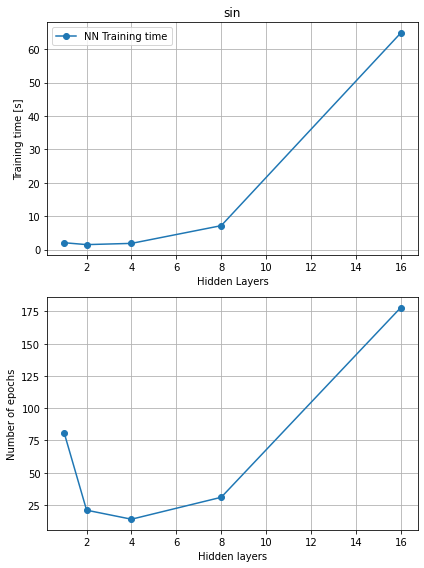

In [ ]:
plt.figure(figsize=(6,8))
plt.subplot(2, 1, 1)
plot(N_layers_list, train_times_hidden_layers, '-o')
plt.title(func_type)
plt.legend(['NN Training time'])
plt.xlabel('Hidden Layers')
plt.ylabel('Training time [s]')
plt.grid()

plt.subplot(2, 1, 2)
plot(N_layers_list, epochs_hidden_layers, '-o')
plt.xlabel('Hidden layers')
plt.ylabel('Number of epochs')
plt.grid()

plt.tight_layout()

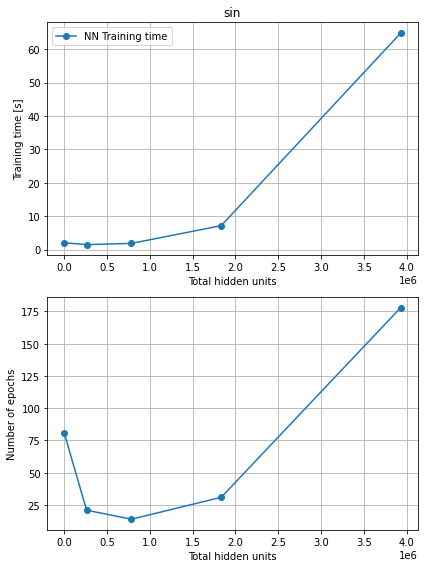

In [ ]:
plt.figure(figsize=(6,8))
plt.subplot(2, 1, 1)
N_params = (torch.Tensor(N_layers_list) - 1)*((2**9)**2)
plt.plot(N_params.detach(), train_times_hidden_layers.detach(), '-o')
plt.title(func_type)
plt.legend(['NN Training time'])
plt.xlabel('Total hidden units')
plt.ylabel('Training time [s]')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(N_params.detach(), epochs_hidden_layers.detach(), '-o')
plt.xlabel('Total hidden units')
plt.ylabel('Number of epochs')
plt.grid()

plt.tight_layout()

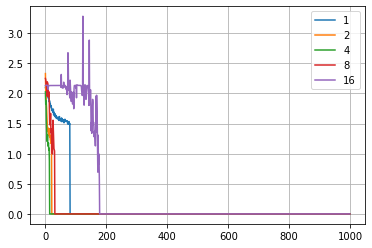

In [ ]:
plot(range(max_epochs), losses_hidden_layers_test.T)
plt.legend([str(N_layers) for N_layers in N_layers_list])
plt.grid()
plt.show()